# Learn from cleanrl implementation

https://github.com/vwxyzjn/cleanrl/blob/master/cleanrl/dqn.py

# import

In [1]:
import gymnasium as gym
import seaborn as sns
import os
from collections import deque, Counter, namedtuple, defaultdict
import random
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.nn import init
import torch.nn.functional as F
from torch.distributions import Categorical
import math
from itertools import count
from tqdm import tqdm
import numpy as np
import time
import uuid
import pickle
from tqdm import tqdm


from stable_baselines3.common.atari_wrappers import (
    ClipRewardEnv, 
    EpisodicLifeEnv, #make end of life = end of episode
    FireResetEnv,
    MaxAndSkipEnv,
    NoopResetEnv
)

from stable_baselines3.common.buffers import ReplayBuffer

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

SEED = 42

#seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Hyperparams

In [2]:
ENV_ARGS = {
    'id': 'AssaultNoFrameskip-v0'
}

ROOT = os.getcwd()
OUTPUT = os.path.join(ROOT, 'output', ENV_ARGS['id'])

if os.path.exists(OUTPUT) == False:
    os.makedirs(OUTPUT)

NUM_ENVS = 3
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device = ", DEVICE)

device =  cuda


# env wrapper

In [3]:
def make_env(**env_args):
    env = gym.make(**env_args)
    env = gym.wrappers.RecordEpisodeStatistics(env)
    env = NoopResetEnv(env)
    env = MaxAndSkipEnv(env)
    env = EpisodicLifeEnv(env)
    if "FIRE" in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = ClipRewardEnv(env)
    env = gym.wrappers.ResizeObservation(env, (84, 84))
    env = gym.wrappers.GrayScaleObservation(env)
    env = gym.wrappers.FrameStack(env, 4)

    return env

# Qnetwork

In [4]:
class QNetwork(nn.Module):
    def __init__(self, envs: gym.Env, fc_hidden_size = 512 ):

        super().__init__()

        self.state_shape = np.prod(envs.single_observation_space.shape)
        self.action_shape = np.prod(envs.single_action_space.n)

        self.network = nn.Sequential(
            nn.LazyConv2d(32, 8, stride = 4),
            nn.ReLU(),
            nn.LazyConv2d(64, 4, stride = 2),
            nn.ReLU(),
            nn.LazyConv2d(64, 3, stride = 1),
            nn.ReLU(),
            nn.Flatten(),
            nn.LazyLinear(fc_hidden_size),
            nn.ReLU(),
            nn.LazyLinear(self.action_shape),
        )

    def forward(self, x):
        return self.network(x/255.0)


In [5]:
# Test running network on env

# Test env
envs = gym.vector.SyncVectorEnv(
    [lambda : make_env(**ENV_ARGS) for _ in range(NUM_ENVS)]
) 

assert isinstance(envs.single_action_space, gym.spaces.Discrete), 'Only discrete action is supported'

obs, info = envs.reset()
obs = torch.tensor(obs)
print('observation shape = ', obs.shape)
print('observation shape = ', envs.single_action_space.n)

qnet = QNetwork(envs)

action = qnet(obs)

print('action shape = ', action.shape)


observation shape =  torch.Size([3, 4, 84, 84])
observation shape =  7
action shape =  torch.Size([3, 7])


c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


# Epsilone decay function

In [6]:
def linear_schedule(start_e: int, end_e:int , total_t:int , t:int ):
    # epsilone value decays linear
    slope = (end_e - start_e) / total_t
    return max(slope * t + start_e, end_e)

def plot_schedule(function, start_e, end_e, duration, explore_fraction = 1.0):
    #  explore for some time, then only exploit (epsilon stays at end_e)
    data = []

    for t in range(duration):
        v = function(start_e, end_e, int(explore_fraction * duration), t)
        data.append(v)
    
    sns.lineplot(y = data, x = list(range(len(data))))
    plt.title('schedule plot')
    plt.show()

def plot(history, show = False, save_path = None):
    sns.lineplot(y = history['reward'], x = list(range(len(history['reward']))))

    if save_path != None:
        plt.savefig(save_path)
    if show:
        plt.show()
        
    plt.clf()
    plt.close()

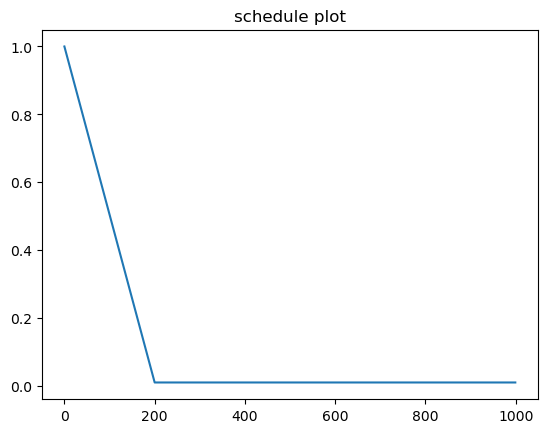

In [7]:
# Test
plot_schedule(linear_schedule, 1.0, 0.01, 1000, 0.2)

# Training loop

In [8]:
def replay_buffer_usage(rb: ReplayBuffer):
    return (rb.pos / rb.buffer_size) * 100 if rb.full == False else 100

def tune(envs, policy_net, target_net, optimizer, start_ep, end_ep, gamma,
    explore_fraction = 0.3, 
    buffer_size=int(1e6), batch_size = 32,
    total_timesteps = int(10e6), warmup_steps = 5000, skip_steps = 4,
    device = DEVICE, plot_update_freq = 5, target_sync_freq = 4, tau = 1.0,
    label = 'baseline'):

    observation_space = envs.single_observation_space
    action_space = envs.single_action_space
    n_envs = envs.observation_space.shape[0]

    SAVE_PATH = os.path.join(OUTPUT, label)
    FIG_SAVE_PATH = os.path.join(SAVE_PATH, 'plot.png')

    if os.path.exists(SAVE_PATH) == False:
        os.makedirs(SAVE_PATH)

    print('save path = ', SAVE_PATH)

    replay_buffer = ReplayBuffer(
        buffer_size,
        observation_space,
        action_space,
        device,
        n_envs=n_envs,
        optimize_memory_usage=True,
        handle_timeout_termination=False
    )

    obs, _ = envs.reset()
    loop = tqdm(range(total_timesteps))

    score_window = deque(maxlen=100)
    loss_window = deque(maxlen=100)
    history = defaultdict(list)

    optimize_count = 0
    sync_count = 0
    loss = None
    buffer_current_size = 0
    episode_count = 0
    start = time.time()
    updated_t = 0
    best_score = -float('inf')

    for global_step in loop:
        #get elapsed time in seconds
        t = int(loop.format_dict['elapsed'])

        epsilon = linear_schedule(start_ep, end_ep, int( explore_fraction *  total_timesteps), global_step)

        #greedy epsilon 
        p = random.random()

        if epsilon > p:
            #explore
            actions = np.array([envs.single_action_space.sample() for _ in range(n_envs)])
        else:
            action_pred = policy_net(torch.tensor(obs).to(device)) 
            actions = torch.argmax(action_pred, dim = 1).cpu().numpy()
        
        # print('actions = ', actions.shape)
        
        next_obs, rewards, terminated, truncated, infos = envs.step(actions)

        if 'final_info' in infos:
            for k,v in infos.items():
                for info in infos['final_info']:
                    if info and 'episode' in info:
                        ep_return = info['episode']['r']
                        score_window.append(ep_return)
                        episode_count += 1

                        avg_reward = np.mean(score_window)
                        avg_loss = np.mean(loss_window)
                        history['reward'].append(avg_reward)

                        #save model with new best score 
                        if avg_reward > best_score:
                            best_score = avg_reward
                            torch.save(policy_net, os.path.join(SAVE_PATH, 'policy.checkpoint.torch'))
                            torch.save(target_net, os.path.join(SAVE_PATH, 'target.checkpoint.torch'))
        
        #save transition to replay buffer
        real_next_obs = next_obs.copy()
        for idx, trunc in enumerate(truncated):
            if trunc:
                real_next_obs[idx] = infos["final_observation"][idx]
        
        replay_buffer.add(obs, real_next_obs, actions, rewards, terminated, infos)
        buffer_current_size += 1

        obs = next_obs

        #training with DQN algorithm
        if global_step > warmup_steps:
            if global_step % skip_steps == 0:
                optimize_count += 1
                b_obs, b_actions, b_next_obs, b_dones, b_rewards = replay_buffer.sample(batch_size)
                data = replay_buffer.sample(batch_size)

                with torch.no_grad():
                    target_value = target_net(b_next_obs).max(1).values
                    td_target = b_rewards.flatten() + gamma * target_value * (1 - b_dones.flatten())
                
                old_value = policy_net(b_obs).gather(1, b_actions).squeeze()

                loss = F.mse_loss(td_target, old_value)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                loss_window.append(loss.item())

                if global_step % target_sync_freq == 0:
                    #perform soft update
                    sync_count += 1
                    target_net.load_state_dict(policy_net.state_dict())

            if t != updated_t and t % plot_update_freq == 0: 
                plot(history, save_path = FIG_SAVE_PATH)
                updated_t = t
                loop.set_description(f"epsilon = {epsilon:.2f}, episode={episode_count}, avg_reward = {avg_reward:.2f}, buffer usage = {replay_buffer_usage(replay_buffer):.2f}")



    plot(history, show = True, save_path = FIG_SAVE_PATH)
    
    with open(os.path.join(SAVE_PATH, 'history.pickle'), 'wb') as file:
        pickle.dump(history, file)


observation shape =  torch.Size([3, 4, 84, 84])
observation shape =  7
save path =  e:\ML\NLP\Reinforcement Learning\deep rl\dqn\output\AssaultNoFrameskip-v0\baseline


c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\stable_baselines3\common\buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 28.24GB > 0.34GB
  warnings.warn(
epsilon = 0.01, episode=33810, avg_reward = 174.30, buffer usage = 100.00:  56%|█████▌    | 1120953/2000000 [5:12:20<4:04:56, 59.82it/s] 


MemoryError: cannot allocate memory for array

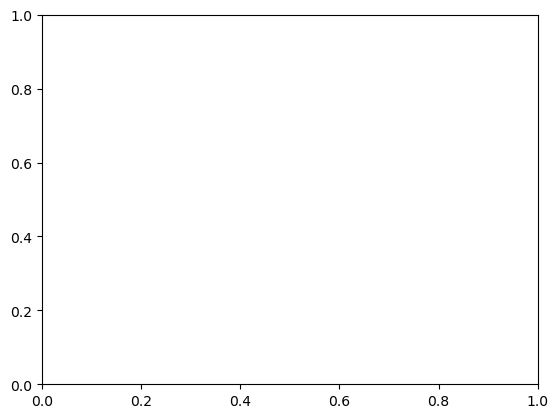

In [9]:
#parameter
lr = 1e-4
start_ep = 1.0
end_ep = 0.01
total_timesteps = int(2e6)
device = DEVICE
gamma = 0.99
plot_update_freq = 10
# fc_hidden_size = 128
buffer_size = int(1e6)
batch_size = 32
warmup_steps = 1000
explore_fraction = 0.1

# Test env
envs = gym.vector.SyncVectorEnv(
    [lambda : make_env(**ENV_ARGS) for _ in range(NUM_ENVS)]
) 

assert isinstance(envs.single_action_space, gym.spaces.Discrete), 'Only discrete action is supported'

obs, info = envs.reset()
obs = torch.tensor(obs)
print('observation shape = ', obs.shape)
print('action shape = ', envs.single_action_space.n)

policy_net = QNetwork(envs).to(device)
target_net = QNetwork(envs).to(device)

target_net.load_state_dict(policy_net.state_dict())

optimizer = torch.optim.Adam(policy_net.parameters(), lr = lr)

tune(envs, policy_net, target_net, optimizer, 
start_ep = start_ep, end_ep = end_ep, gamma= gamma, explore_fraction = explore_fraction,
buffer_size=buffer_size, batch_size = batch_size,
device = device, total_timesteps=total_timesteps, plot_update_freq= plot_update_freq, warmup_steps=warmup_steps)
